## Multislice Reconstructions

In this tutorial, we'll how for sufficiently thick samples the multiplicative assumption for our exit wave forward model

$$
\psi_{j \boldsymbol{r}} = P_{\boldsymbol{r}} \times O_{\boldsymbol{r}-\boldsymbol{R}_j}
$$

breaks down, and how [multislice ptychography](https://doi.org/10.1364/JOSAA.29.001606) accounts for this by including free-space propagation in its forward model:

$$
\begin{aligned}
\psi_{j \boldsymbol{r}}^n &= P^n_{\boldsymbol{r}} \times O^n_{\boldsymbol{r}-\boldsymbol{R}_j} \\
P^{n+1}_{\boldsymbol{r}}  &= \mathrm{Prop}_{\Delta Z_n}\left[ \psi_{j \boldsymbol{r}}^n \right]
\end{aligned}
$$

We'll consider the same slab of [110] STO, but four times thicker:

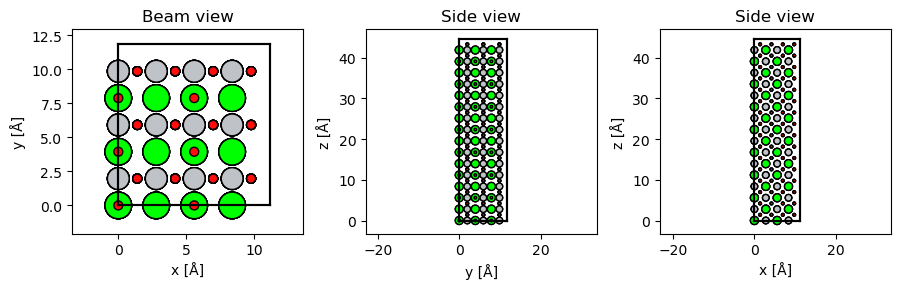

In [1]:
from ase.io import read
from ase import Atoms
from ase.build import surface
from matplotlib import pyplot as plt

STO_unit_cell = read("../data/SrTiO3.cif")
STO_atoms = surface(STO_unit_cell, (1, 1, 0), 4, periodic=True) * (2, 3, 1)
STO_atoms_thick = STO_atoms * (1, 1, 4)

from abtem import show_atoms

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))

show_atoms(STO_atoms_thick, ax=ax1, title="Beam view")
show_atoms(STO_atoms_thick, ax=ax2, plane="yz", title="Side view")
show_atoms(STO_atoms_thick, ax=ax3, plane="xz", title="Side view")

fig.tight_layout();

In [2]:
from abtem import Potential, FrozenPhonons, Probe, CTF
from abtem.detect import AnnularDetector, PixelatedDetector
from abtem.scan import GridScan
from abtem.noise import poisson_noise

potential_thick = Potential(
    STO_atoms_thick,
    sampling=0.02,
    device="gpu",
    projection="infinite",
    parametrization="kirkland",
)

ctf = CTF(
    parameters={"C10": -75, "C12": 20, "phi12": 0.785, "C30": -7e4}, semiangle_cutoff=24
)
probe = Probe(semiangle_cutoff=24, energy=200e3, ctf=ctf, device="gpu")
probe.match_grid(potential_thick)

pixelated_detector = PixelatedDetector(max_angle=120)
gridscan = GridScan(
    (0, 0), potential_thick.extent, sampling=0.9 * probe.ctf.nyquist_sampling
)
measurement_thick = probe.scan(gridscan, pixelated_detector, potential_thick)
measurement_noise = poisson_noise(measurement_thick, 1e6)

Potential:   0%|          | 0/90 [00:00<?, ?it/s]

Scan:   0%|          | 0/2350 [00:00<?, ?it/s]

First, let's see Regularized-PIE breakdown already for a sample of this thickness:

In [3]:
from abtem.reconstruct import RegularizedPtychographicOperator

msrpie_reconstruction_ptycho_operator = RegularizedPtychographicOperator(
    measurement_noise,
    semiangle_cutoff=24,
    energy=200e3,
    device="gpu",
    parameters={"object_px_padding": (0, 0)},
).preprocess()

(
    msrpie_objects,
    msrpie_probes,
    msrpie_positions,
    msrpie_sse,
) = msrpie_reconstruction_ptycho_operator.reconstruct(
    max_iterations=5,
    random_seed=1,
    verbose=True,
    return_iterations=True,
    parameters={
        "pure_phase_object_update_steps": msrpie_reconstruction_ptycho_operator._num_diffraction_patterns
    },
)

Ptychographic reconstruction will perform the following steps:
--Regularized PIE for 11750 steps
--Probe correction is enabled
--Reconstructed object will be constrained to a pure-phase object for the first 2350 steps


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2350 [00:00<?, ?it/s]

----Iteration 0, SSE = 1.253e-05
----Iteration 1, SSE = 6.014e-06
----Iteration 2, SSE = 5.713e-06
----Iteration 3, SSE = 5.666e-06
----Iteration 4, SSE = 5.666e-06


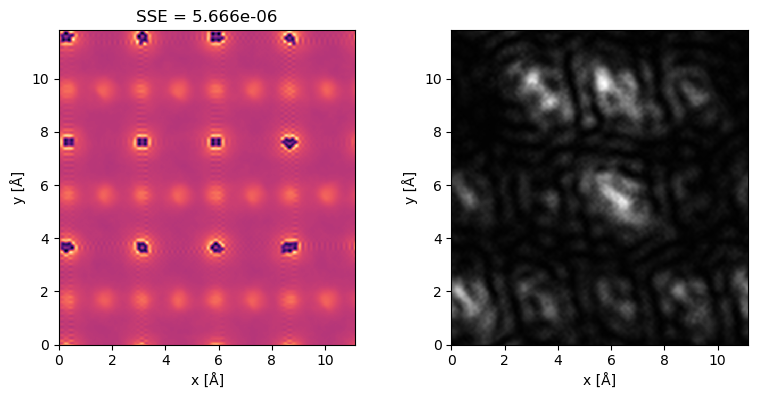

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

msrpie_objects[-1].angle().interpolate(potential_thick.sampling).show(
    cmap="magma", ax=ax1, title=f"SSE = {float(msrpie_sse[-1]):.3e}"
)
msrpie_probes[-1].intensity().interpolate(potential_thick.sampling).show(ax=ax2)

fig.tight_layout();

Indeed, the e-PIE algorithm does pretty poorly on the thicker sample.  
_Note:_ constraining the reconstructed object to be a pure phase object in the early iterations seems to help, but not enough

Let's see if multislice-PIE performs better. We'll use just two evenly-spaced slices.

For this, we introduce another object called `MultislicePtychographicOperator`, which accepts two additional parameters: `num_slices` and `slice_thicknesses`

In [5]:
from abtem.reconstruct import MultislicePtychographicOperator

slice_thicknesses = STO_atoms_thick.cell.lengths()[-1] / 2
multislice_reconstruction_ptycho_operator = MultislicePtychographicOperator(
    measurement_noise,
    semiangle_cutoff=24,
    energy=200e3,
    num_slices=2,
    slice_thicknesses=slice_thicknesses,
    device="gpu",
    parameters={"object_px_padding": (0, 0)},
).preprocess()

(
    mspie_objects,
    mspie_probes,
    mspie_positions,
    mspie_sse,
) = multislice_reconstruction_ptycho_operator.reconstruct(
    max_iterations=5,
    verbose=True,
    random_seed=1,
    return_iterations=True,
    parameters={
        "pure_phase_object_update_steps": multislice_reconstruction_ptycho_operator._num_diffraction_patterns
    },
)

Ptychographic reconstruction will perform the following steps:
--Multislice PIE for 11750 steps
--Probe correction is enabled
--Reconstructed object will be constrained to a pure-phase object for the first 2350 steps


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2350 [00:00<?, ?it/s]

----Iteration 0, SSE = 9.118e-06
----Iteration 1, SSE = 3.382e-06
----Iteration 2, SSE = 3.239e-06
----Iteration 3, SSE = 3.209e-06
----Iteration 4, SSE = 3.206e-06


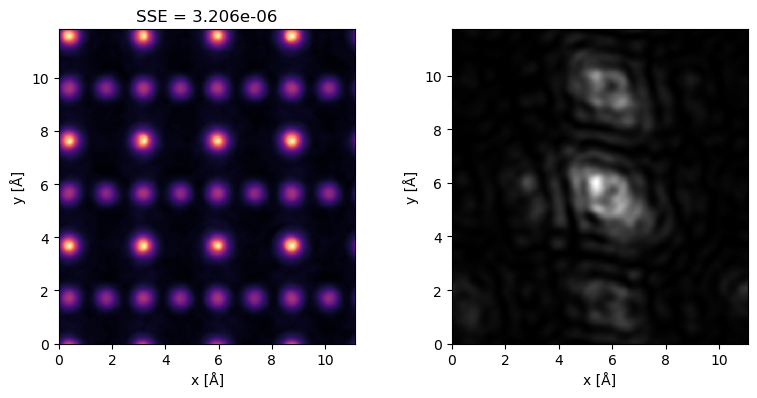

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

mspie_objects[-1].angle().sum(0).interpolate(potential_thick.sampling).show(
    cmap="magma", ax=ax1, title=f"SSE = {float(mspie_sse[-1]):.3e}"
)
mspie_probes[-1][0].intensity().interpolate(potential_thick.sampling).show(ax=ax2)

fig.tight_layout();

This is indeed significantly better!